In [15]:
import sys
import os
import random
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.stock_data import get_data_loaders, StockIndex
from utils.early_stopping import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.88e-05 | test_loss: 3.11e+00 | reg: 1.48e+01 | : 100%|█| 30/30 [00:03<00:00,  8.57it


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.71e-04 | test_loss: 3.29e+00 | reg: 1.42e+01 | : 100%|█| 30/30 [00:03<00:00,  7.85it


saving model version 0.1


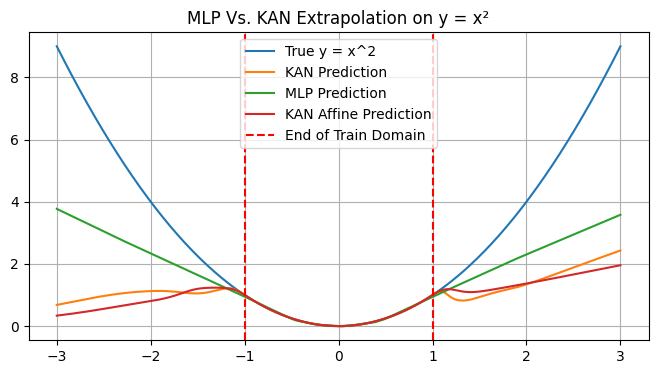

In [16]:
import torch
import matplotlib.pyplot as plt
from kan import KAN  # or your MultKAN wrapper

# Generate data: y = x^2, but train only on part of the domain
x_train = torch.linspace(-1, 1, 100).reshape(-1, 1)
y_train = x_train ** 2

# Test on a broader domain
x_test = torch.linspace(-3, 3, 300).reshape(-1, 1)
y_test = x_test ** 2

# Train a basic KAN
model = KAN(width=[1, 10, 1], grid=5, k=3, seed=0, affine_trainable=False)
dataset = {'train_input': x_train, 'train_label': y_train,
           'test_input': x_test, 'test_label': y_test}
model.fit(dataset, opt='LBFGS', steps=30, lamb=0.0)

# Predict over test domain
with torch.no_grad():
    y_pred_kan = model(x_test)

model = KAN(width=[1, 10, 1], grid=5, k=3, seed=0, affine_trainable=True)
dataset = {'train_input': x_train, 'train_label': y_train,
           'test_input': x_test, 'test_label': y_test}
model.fit(dataset, opt='LBFGS', steps=30, lamb=0.0)

with torch.no_grad():
    y_pred_kan_affine = model(x_test)

# Define a simple MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

mlp = MLP()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Train the MLP
for epoch in range(1000):
    mlp.train()
    optimizer.zero_grad()
    y_pred_train = mlp(x_train)
    loss = loss_fn(y_pred_train, y_train)
    loss.backward()
    optimizer.step()

# Predict on the test set
mlp.eval()
with torch.no_grad():
    y_pred_mlp = mlp(x_test)

plt.figure(figsize=(8, 4))
plt.plot(x_test.numpy(), y_test.numpy(), label='True y = x^2')
plt.plot(x_test.numpy(), y_pred_kan.numpy(), label='KAN Prediction')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), label='MLP Prediction')
plt.plot(x_test.numpy(), y_pred_kan_affine.numpy(), label='KAN Affine Prediction')

plt.axvline(1, color='r', linestyle='--', label='End of Train Domain')
plt.axvline(-1, color='r', linestyle='--')
plt.legend()
plt.title("MLP Vs. KAN Extrapolation on y = x²")
plt.grid(True)
plt.show()
